In [64]:
from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator

In [73]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
df = pd.read_csv('ddb_output.csv')
df.rename(columns={'humidity.S': 'humidity',
                   'temperature.S':'temperature',
                   'timestamp.S':'timestamp'},inplace=True)
df.drop(columns=['Unnamed: 0'],inplace=True)
#df.reset_index(drop=True,inplace=True)
df.sort_values(by='timestamp',inplace=True)
df

,humidity,temperature,timestamp
0,54.00,18.04,2023-04-21 12:36:04.168213
1,54.00,18.13,2023-04-21 12:36:07.120651
2,54.00,18.01,2023-04-21 12:36:10.007948
3,54.00,18.09,2023-04-21 12:36:12.959915
4,52.00,18.08,2023-04-21 15:48:08.632782
...,...,...,...
3041,56.35,21.63,2023-05-10 20:30:04.178828
3042,56.91,21.57,2023-05-10 20:40:04.682990
3043,56.72,21.54,2023-05-10 20:50:04.106947
3044,56.77,21.50,2023-05-10 21:00:04.586745


In [3]:
fig = px.scatter(df, x="timestamp", y=["humidity","temperature"], title='All-time humidity and temperature in the grove!')
fig.show()

In [4]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
go.Scatter(x=df['timestamp'],y=df['temperature'], name="Temperature", mode='markers'),
secondary_y=False,
)

fig.add_trace(
go.Scatter(x=df['timestamp'],y=df['humidity'], name="Humidity", mode='markers'),
secondary_y=True,
)

fig.update_layout(
title_text="Temperature and humidity over time"
)

# Set x-axis title
fig.update_xaxes(title_text="Time")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Temperature</b>", title_font_color='blue', secondary_y=False)
fig.update_yaxes(title_text="<b>Humidity</b>", title_font_color='red', secondary_y=True)

In [5]:
df['date'] = df['timestamp'].map(lambda x: pd.Timestamp(x).date())

In [6]:
df_last_week = df[df['timestamp'] > str(pd.Timestamp('2023-05-1'))]

In [7]:
fig = px.box(df_last_week, x="date", y="temperature")
fig.show()

## Building a forecasting model 

In [8]:
df_temp =  df[ df['timestamp'] > str(pd.Timestamp('2023-04-28')) ].drop(columns=['humidity','date'])
df_temp.reset_index(inplace=True,drop=True)

df_temp['timestamp'] = df_temp['timestamp'].apply(lambda x: pd.Timestamp(x)) 

df_temp['timestamp'] = df_temp['timestamp'].dt.round('5min')
df_temp.head()

,temperature,timestamp
0,17.83,2023-04-28 08:25:00
1,17.85,2023-04-28 08:25:00
2,17.85,2023-04-28 08:30:00
3,17.88,2023-04-28 08:30:00
4,17.88,2023-04-28 09:20:00


In [9]:
px.scatter(df_temp, x='timestamp', y='temperature', title='Temperature from 28 April to May 11th (~12 days)')

### Baseline - persistence forecast 1,2,4 hours in advance

In [10]:
df_temp

,temperature,timestamp
0,17.83,2023-04-28 08:25:00
1,17.85,2023-04-28 08:25:00
2,17.85,2023-04-28 08:30:00
3,17.88,2023-04-28 08:30:00
4,17.88,2023-04-28 09:20:00
...,...,...
2087,21.63,2023-05-10 20:30:00
2088,21.57,2023-05-10 20:40:00
2089,21.54,2023-05-10 20:50:00
2090,21.50,2023-05-10 21:00:00


In [11]:
# Test - to predict temperature 1,2,4 hours in advance

def persistence_n_hours(n):

    timestamps_n_hr = df_temp['timestamp'].apply(lambda x: pd.Timestamp(x) + pd.Timedelta(hours=n))

    df_temp_n_hr_baseline = pd.DataFrame(list(zip(timestamps_n_hr,df_temp['temperature'])))
    df_temp_n_hr_baseline.rename(columns={0:'timestamp', 1:'value'},inplace=True)
    df_temp_n_hr_baseline['type'] = f'persist. {n}hrs'
    df_temp_n_hr_baseline = df_temp_n_hr_baseline[['value', 'timestamp', 'type']]
    df_temp_n_hr_baseline

    return df_temp_n_hr_baseline

persist_1_hr = persistence_n_hours(1)
persist_2_hr = persistence_n_hours(2)
persist_4_hr = persistence_n_hours(4)


In [12]:
df_temp['type'] = 'observation'
df_temp.rename(columns={'temperature':'value'},inplace=True)
df_temp

,value,timestamp,type
0,17.83,2023-04-28 08:25:00,observation
1,17.85,2023-04-28 08:25:00,observation
2,17.85,2023-04-28 08:30:00,observation
3,17.88,2023-04-28 08:30:00,observation
4,17.88,2023-04-28 09:20:00,observation
...,...,...,...
2087,21.63,2023-05-10 20:30:00,observation
2088,21.57,2023-05-10 20:40:00,observation
2089,21.54,2023-05-10 20:50:00,observation
2090,21.50,2023-05-10 21:00:00,observation


In [13]:
df_1_hour_forecast = pd.concat([df_temp, persist_2_hr], axis=0)

df_1_hour_forecast['timestamp'] = df_1_hour_forecast['timestamp'].apply(lambda x: pd.Timestamp(x)) 

df_1_hour_forecast.sort_values(by='timestamp',inplace=True)

df_1_hour_forecast_1_day = df_1_hour_forecast[ df_1_hour_forecast['timestamp'] > str(pd.Timestamp('2023-05-10')) ]

df_1_hour_forecast


,value,timestamp,type
0,17.83,2023-04-28 08:25:00,observation
1,17.85,2023-04-28 08:25:00,observation
2,17.85,2023-04-28 08:30:00,observation
3,17.88,2023-04-28 08:30:00,observation
4,17.88,2023-04-28 09:20:00,observation
...,...,...,...
2087,21.63,2023-05-10 22:30:00,persist. 2hrs
2088,21.57,2023-05-10 22:40:00,persist. 2hrs
2089,21.54,2023-05-10 22:50:00,persist. 2hrs
2090,21.50,2023-05-10 23:00:00,persist. 2hrs


In [14]:

px.scatter(df_1_hour_forecast_1_day, x='timestamp', y='value', color='type', title='Temperature from 28 April to May 11th (~12 days)')

In [15]:
df_1_hour_forecast['value'] = df_1_hour_forecast['value'].astype(float)

In [16]:
# This works but not where there's NaN

persistence_forecast_1_hr = df_1_hour_forecast.pivot_table(values='value', index='timestamp', columns='type').head(-20)
persistence_forecast_1_hr['rel_error'] = persistence_forecast_1_hr['observation'] - persistence_forecast_1_hr['persist. 2hrs']
persistence_forecast_1_hr['abs_error'] = abs(persistence_forecast_1_hr['observation'] - persistence_forecast_1_hr['persist. 2hrs'] )

persistence_forecast_1_hr

persistence_forecast_1_hr_errors = persistence_forecast_1_hr[['rel_error','abs_error']]
persistence_forecast_1_hr_errors.reset_index(inplace=True)

persistence_forecast_1_hr_errors = persistence_forecast_1_hr_errors.melt(id_vars='timestamp')
persistence_forecast_1_hr_errors

px.scatter(persistence_forecast_1_hr_errors, x='timestamp', y='value', color='type', title='Errors from a 1-hr persistence forecast')

In [17]:
persistence_forecast_1_hr_errors

,timestamp,type,value
0,2023-04-28 08:25:00,rel_error,NaN
1,2023-04-28 08:30:00,rel_error,NaN
2,2023-04-28 09:20:00,rel_error,NaN
3,2023-04-28 09:30:00,rel_error,NaN
4,2023-04-28 09:40:00,rel_error,NaN
...,...,...,...
4179,2023-05-10 19:10:00,abs_error,0.03
4180,2023-05-10 19:20:00,abs_error,0.01
4181,2023-05-10 19:30:00,abs_error,0.03
4182,2023-05-10 19:40:00,abs_error,0.04


In [18]:
df_temp =  df[ df['timestamp'] > str(pd.Timestamp('2023-04-28')) ].drop(columns=['humidity','date'])
df_temp.reset_index(inplace=True,drop=True)

df_temp['timestamp'] = df_temp['timestamp'].apply(lambda x: pd.to_datetime(x)) 

df_temp['timestamp'] = df_temp['timestamp'].dt.round('5min')

df_temp['timestamp'] = df_temp['timestamp'].apply(lambda x: pd.to_datetime(x)) 

df_temp.set_index('timestamp',inplace=True)
df_temp

,temperature
timestamp,
2023-04-28 08:25:00,17.83
2023-04-28 08:25:00,17.85
2023-04-28 08:30:00,17.85
2023-04-28 08:30:00,17.88
2023-04-28 09:20:00,17.88
...,...
2023-05-10 20:30:00,21.63
2023-05-10 20:40:00,21.57
2023-05-10 20:50:00,21.54


In [19]:
df_temp.dropna(inplace=True)

# Some quick code to set this up: https://github.com/nachi-hebbar/Time-Series-Forecasting-LSTM

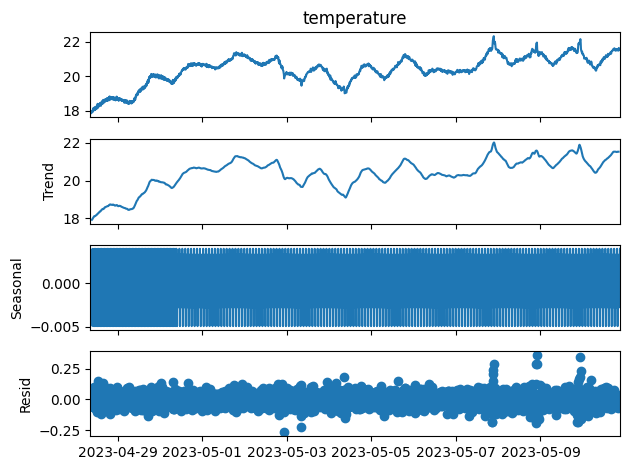

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

results = seasonal_decompose(df_temp['temperature'], period=10)
results.plot()
pyplot.show()

In [21]:
temp_array = df_temp['temperature'][0:100].values
temp_array

array([17.83, 17.85, 17.85, 17.88, 17.88, 17.97, 17.92, 17.99, 17.95,
       18.01, 18.01, 17.97, 17.97, 17.95, 17.97, 18.06, 18.15, 18.06,
       18.11, 18.16, 18.05, 18.11, 18.15, 18.09, 18.08, 18.19, 18.12,
       18.05, 18.12, 18.06, 18.19, 18.16, 18.15, 18.11, 18.22, 18.24,
       18.11, 18.18, 18.15, 18.21, 18.21, 18.22, 18.13, 18.22, 18.39,
       18.22, 18.32, 18.26, 18.21, 18.19, 18.28, 18.28, 18.35, 18.29,
       18.32, 18.39, 18.28, 18.39, 18.34, 18.31, 18.42, 18.39, 18.31,
       18.39, 18.39, 18.38, 18.46, 18.28, 18.4 , 18.42, 18.45, 18.45,
       18.47, 18.5 , 18.52, 18.52, 18.55, 18.39, 18.43, 18.42, 18.53,
       18.53, 18.62, 18.45, 18.47, 18.49, 18.46, 18.52, 18.55, 18.59,
       18.49, 18.55, 18.6 , 18.57, 18.52, 18.59, 18.66, 18.67, 18.6 ,
       18.6 ])

In [33]:

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [49]:
df_temp

,temperature
timestamp,
2023-04-28 08:25:00,17.83
2023-04-28 08:25:00,17.85
2023-04-28 08:30:00,17.85
2023-04-28 08:30:00,17.88
2023-04-28 09:20:00,17.88
...,...
2023-05-10 20:30:00,21.63
2023-05-10 20:40:00,21.57
2023-05-10 20:50:00,21.54


In [51]:
# Split the data, 70% in training and 30% in test, and not randomly selected since this is a time series

last_train_index = int(np.round(df_temp['temperature'].shape[0]*0.7))

train_data = df_temp.iloc[:last_train_index,]
test_data = df_temp.iloc[last_train_index:,]

# Fit to the train set, then transform the train set and the test set
# TODO: Check, should not fit on test set?

scaler.fit(train_data)
scaled_train = scaler.transform(train_data)
scaled_test = scaler.transform(test_data)


In [66]:

train = keras.utils.timeseries_dataset_from_array(
    data=scaled_train[:-3],
    targets=scaled_train[3:],
    sequence_length=3,
    batch_size=1,
    shuffle=True
)

test = keras.utils.timeseries_dataset_from_array(
    data=scaled_test[:-3],
    targets=scaled_test[3:],
    sequence_length=3,
    batch_size=1,
    shuffle=True
)

train_2 = TimeseriesGenerator(scaled_train[:-3], scaled_train[3:], length=3, batch_size=1, shuffle=True)
test_2 = TimeseriesGenerator(scaled_test[:-3], scaled_test[3:], length=3, batch_size=1, shuffle=True)

print(train)
print(test)

print(train_2)
print(test_2)

# for inputs, targets in dummy_dataset:
#     for i in range(inputs.shape[0]):
#         print([float(x) for x in inputs[i]],float(targets[i]))

<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>


In [32]:
# An alternative, using TimeseriesGenerator 


n_input = 3
n_features = 1
generator = TimeseriesGenerator(temp_array, temp_array, length=n_input, batch_size=1, shuffle=True)

for inputs, targets in generator:
    print('Inputs :', inputs, ', targets: ', targets)

Inputs : [[18.31 18.42 18.39]] , targets:  [18.31]
Inputs : [[18.42 18.39 18.31]] , targets:  [18.39]
Inputs : [[18.28 18.39 18.34]] , targets:  [18.31]
Inputs : [[18.06 18.11 18.16]] , targets:  [18.05]
Inputs : [[18.15 18.11 18.22]] , targets:  [18.24]
Inputs : [[18.19 18.12 18.05]] , targets:  [18.12]
Inputs : [[18.16 18.15 18.11]] , targets:  [18.22]
Inputs : [[18.38 18.46 18.28]] , targets:  [18.4]
Inputs : [[18.16 18.05 18.11]] , targets:  [18.15]
Inputs : [[18.19 18.16 18.15]] , targets:  [18.11]
Inputs : [[18.15 18.21 18.21]] , targets:  [18.22]
Inputs : [[18.15 18.11 18.22]] , targets:  [18.24]
Inputs : [[18.09 18.08 18.19]] , targets:  [18.12]
Inputs : [[18.18 18.15 18.21]] , targets:  [18.21]
Inputs : [[18.52 18.55 18.59]] , targets:  [18.49]
Inputs : [[18.55 18.39 18.43]] , targets:  [18.42]
Inputs : [[18.11 18.18 18.15]] , targets:  [18.21]
Inputs : [[18.11 18.16 18.05]] , targets:  [18.11]
Inputs : [[18.46 18.52 18.55]] , targets:  [18.59]
Inputs : [[17.95 18.01 18.01]] ,

In [60]:
from keras import layers

inputs = keras.Input(shape=(3, 1))

x = layers.LSTM(4)(inputs)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)


model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train,
                    epochs=5,
                    validation_data=test)


Epoch 1/5


2023-05-13 10:09:11.617936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-13 10:09:11.619777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-13 10:09:11.621667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1450/1459 [============================>.] - ETA: 0s - loss: 0.0351 - mae: 0.1209

2023-05-13 10:09:17.892484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-05-13 10:09:17.893245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [625,1]
	 [[{{node Placeholder/_20}}]]
2023-05-13 10:09:18.072274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype in

1459/1459 [==============================] - 7s 4ms/step - loss: 0.0349 - mae: 0.1202 - val_loss: 0.0024 - val_mae: 0.0357
Epoch 2/5
1459/1459 [==============================] - 6s 4ms/step - loss: 4.9427e-04 - mae: 0.0175 - val_loss: 0.0017 - val_mae: 0.0299
Epoch 3/5
1459/1459 [==============================] - 6s 4ms/step - loss: 4.7286e-04 - mae: 0.0170 - val_loss: 0.0019 - val_mae: 0.0313
Epoch 4/5
1459/1459 [==============================] - 5s 4ms/step - loss: 4.6715e-04 - mae: 0.0169 - val_loss: 0.0015 - val_mae: 0.0282
Epoch 5/5
1459/1459 [==============================] - 5s 4ms/step - loss: 4.6047e-04 - mae: 0.0168 - val_loss: 0.0018 - val_mae: 0.0312


In [61]:
print(f"Test MAE: {model.evaluate(test)[1]:.2f}")

623/623 [==============================] - 1s 2ms/step - loss: 0.0018 - mae: 0.0312
Test MAE: 0.03


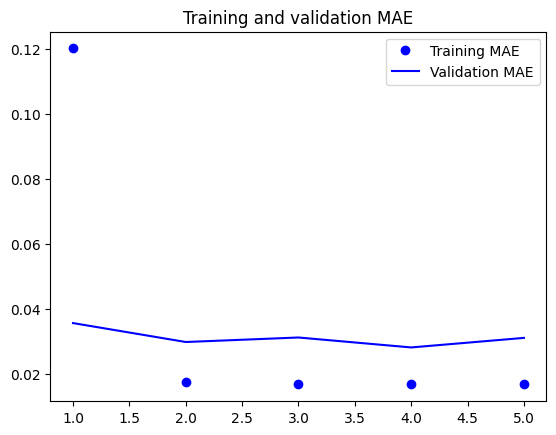

In [62]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [70]:
inputs = keras.Input(shape=(3, 1))

x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)


model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_2,
                    epochs=5,
                    validation_data=test_2)


Epoch 1/5


2023-05-13 10:15:34.041622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-13 10:15:34.043304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-13 10:15:34.044669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1456/1458 [============================>.] - ETA: 0s - loss: 0.0160 - mae: 0.0570

2023-05-13 10:15:40.496897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-13 10:15:40.673777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-13 10:15:40.675523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

1458/1458 [==============================] - 8s 4ms/step - loss: 0.0160 - mae: 0.0569 - val_loss: 0.0018 - val_mae: 0.0291
Epoch 2/5
1458/1458 [==============================] - 5s 4ms/step - loss: 9.7160e-04 - mae: 0.0239 - val_loss: 0.0022 - val_mae: 0.0357
Epoch 3/5
1458/1458 [==============================] - 6s 4ms/step - loss: 8.9684e-04 - mae: 0.0234 - val_loss: 0.0016 - val_mae: 0.0302
Epoch 4/5
1458/1458 [==============================] - 6s 4ms/step - loss: 8.6347e-04 - mae: 0.0228 - val_loss: 0.0024 - val_mae: 0.0356
Epoch 5/5
1458/1458 [==============================] - 7s 4ms/step - loss: 8.8601e-04 - mae: 0.0232 - val_loss: 0.0018 - val_mae: 0.0300


In [71]:
print(f"Test MAE: {model.evaluate(test)[1]:.2f}")

  1/623 [..............................] - ETA: 4:28 - loss: 3.9538e-04 - mae: 0.0199

2023-05-13 10:16:29.492038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-13 10:16:29.494027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-13 10:16:29.495343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

623/623 [==============================] - 2s 2ms/step - loss: 7.6292e-04 - mae: 0.0210
Test MAE: 0.02


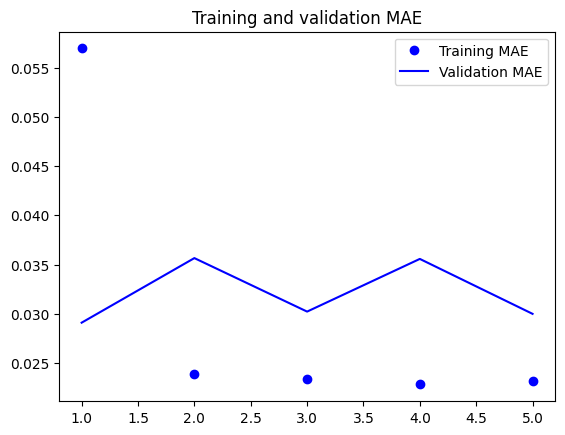

In [72]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Autocorrelation - test using Durbin-Watson test

In [26]:
# Keras - time series forecasting example 

# https://keras.io/examples/adsf/timeseries_weather_forecasting/